# **Unsupervised Scalable Representation Learning for Multivariate Time Series**

**Time Series Learning Project**

This notebook implements some of the experiment we did to better understand the main idea of the paper. 

Contains:

* Analysis of the model on Univariate time series (DodgerLoopDay dataset)
* Analysis of the model on Multivariate time series (BasicMotions dataset)

With each time some exploratory experiments.

# Initialization

In [34]:
%load_ext autoreload
%autoreload 2

import sys
import os
import json
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import torch

from datamodule import TimeSeriesDataModule
from model import (Chomp1d, SqueezeChannels, CausalConvolutionBlock, CausalCNN, CausalCNNEncoder)
from utils import (load_UCR_dataset)
from loss import TripletLoss

root_data = './data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Univariate time series - BasicMotions

This section aims at studying the article in the context of univariate time series. As an exploratory example, we used the dataset **DodgerLoopDay **:
    
        "The traffic data are collected with the loop sensor installed on ramp for the 101 North freeway in Los Angeles. This location is close to Dodgers Stadium; therefore the traffic is affected by volume of visitors to the stadium. Missing values are represented with NaN. The classes are days of the week. - Class 1: Sunday - Class 2: Monday - Class 3: Tuesday - Class 4: Wednesday - Class 5: Thursday - Class 6: Friday - Class 7: Saturday."

This section contains:
* Some experiments on our model, dataloader, and loss, on this univariate dataset.

![image.png](imgs/DodgerLoopDay_img.png)

**Importation of the data**

In [53]:
X_train, y_train, X_test, y_test = load_UCR_dataset(root_data,'DodgerLoopDay')

print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))


X_train: (78, 1, 288)
y_train: (78,)
X_test: (80, 1, 288)
y_test: (80,)


In [80]:
# Optimization parameters 
batch_size = 20
num_workers = 1
epochs = 30
betas = (0.9, 0.999)
weight_decay = 1e-2
lr = 0.0001

# Model parameter 
in_channels = 1
channels = 40
depth = 4
reduced_size = 160
out_channels = 320
kernel_size = 3
N_sample = 288

# Data parameters
train_path = os.path.join(root_data,'DodgerLoopDay','DodgerLoopDay_TRAIN.tsv')
val_path = os.path.join(root_data,'DodgerLoopDay','DodgerLoopDay_TEST.tsv')


# DataLoader importation
DataLoader = TimeSeriesDataModule(train_path, val_path, batch_size, num_workers, min_length=20, multivariate=False)
DataLoader.setup()
train_dataloader = DataLoader.train_dataloader()
test_dataloader = DataLoader.test_dataloader()


# Model definition
encoder = CausalCNNEncoder(in_channels = in_channels, channels = channels, depth = depth,
                         reduced_size = reduced_size, out_channels = out_channels, kernel_size = kernel_size)

# Optimizer definition
optimizer = torch.optim.AdamW(encoder.parameters(), betas = betas, lr = lr, weight_decay = weight_decay)

# Loss definition
loss = TripletLoss()


# Now the goal is to fit the encoder

(ref, pos) =next(iter(train_dataloader))
loss(model(ref[:,None,:]), model(pos[:,None,:]))


tensor(nan, grad_fn=<MeanBackward0>)

# Multivariate time series - BasicMotions

This section aims at studying the article in the context of multivariate time series. As an exploratory example, we used the dataset **Basic Motions**:
    
        "The data was generated as part of a student project where four students performed four activities whilst wearing a smart watch. The watch collects 3D accelerometer and a 3D gyroscope It consists of four classes, which are walking, resting, running and badminton. Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period."

This section contains:
* A visualization of the dataset
* Some experiments on the model provided by the author, on this multivariate dataset

**Importation of the data**

In [13]:
# Load the data
from pyts.datasets import load_basic_motions,uea_dataset_list
X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)

**Normalization**

In [14]:
# Preprocessing: normalization
X_train = (X_train - X_train.mean(axis=2)[:,:,None])/X_train.std(axis=2)[:,:,None]
X_test = (X_test - X_test.mean(axis=2)[:,:,None])/X_test.std(axis=2)[:,:,None]


X_train = torch.from_numpy(X_train).double()
X_test = torch.from_numpy(X_test).double()
if torch.cuda.is_available():
    X_train = X_train.cuda()
    X_test = X_test.cuda()

## Visualization

    The data was generated as part of a student project where four students performed four activities whilst wearing a smart watch. The watch collects 3D accelerometer and a 3D gyroscope It consists of four classes, which are walking, resting, running and badminton. Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period.**


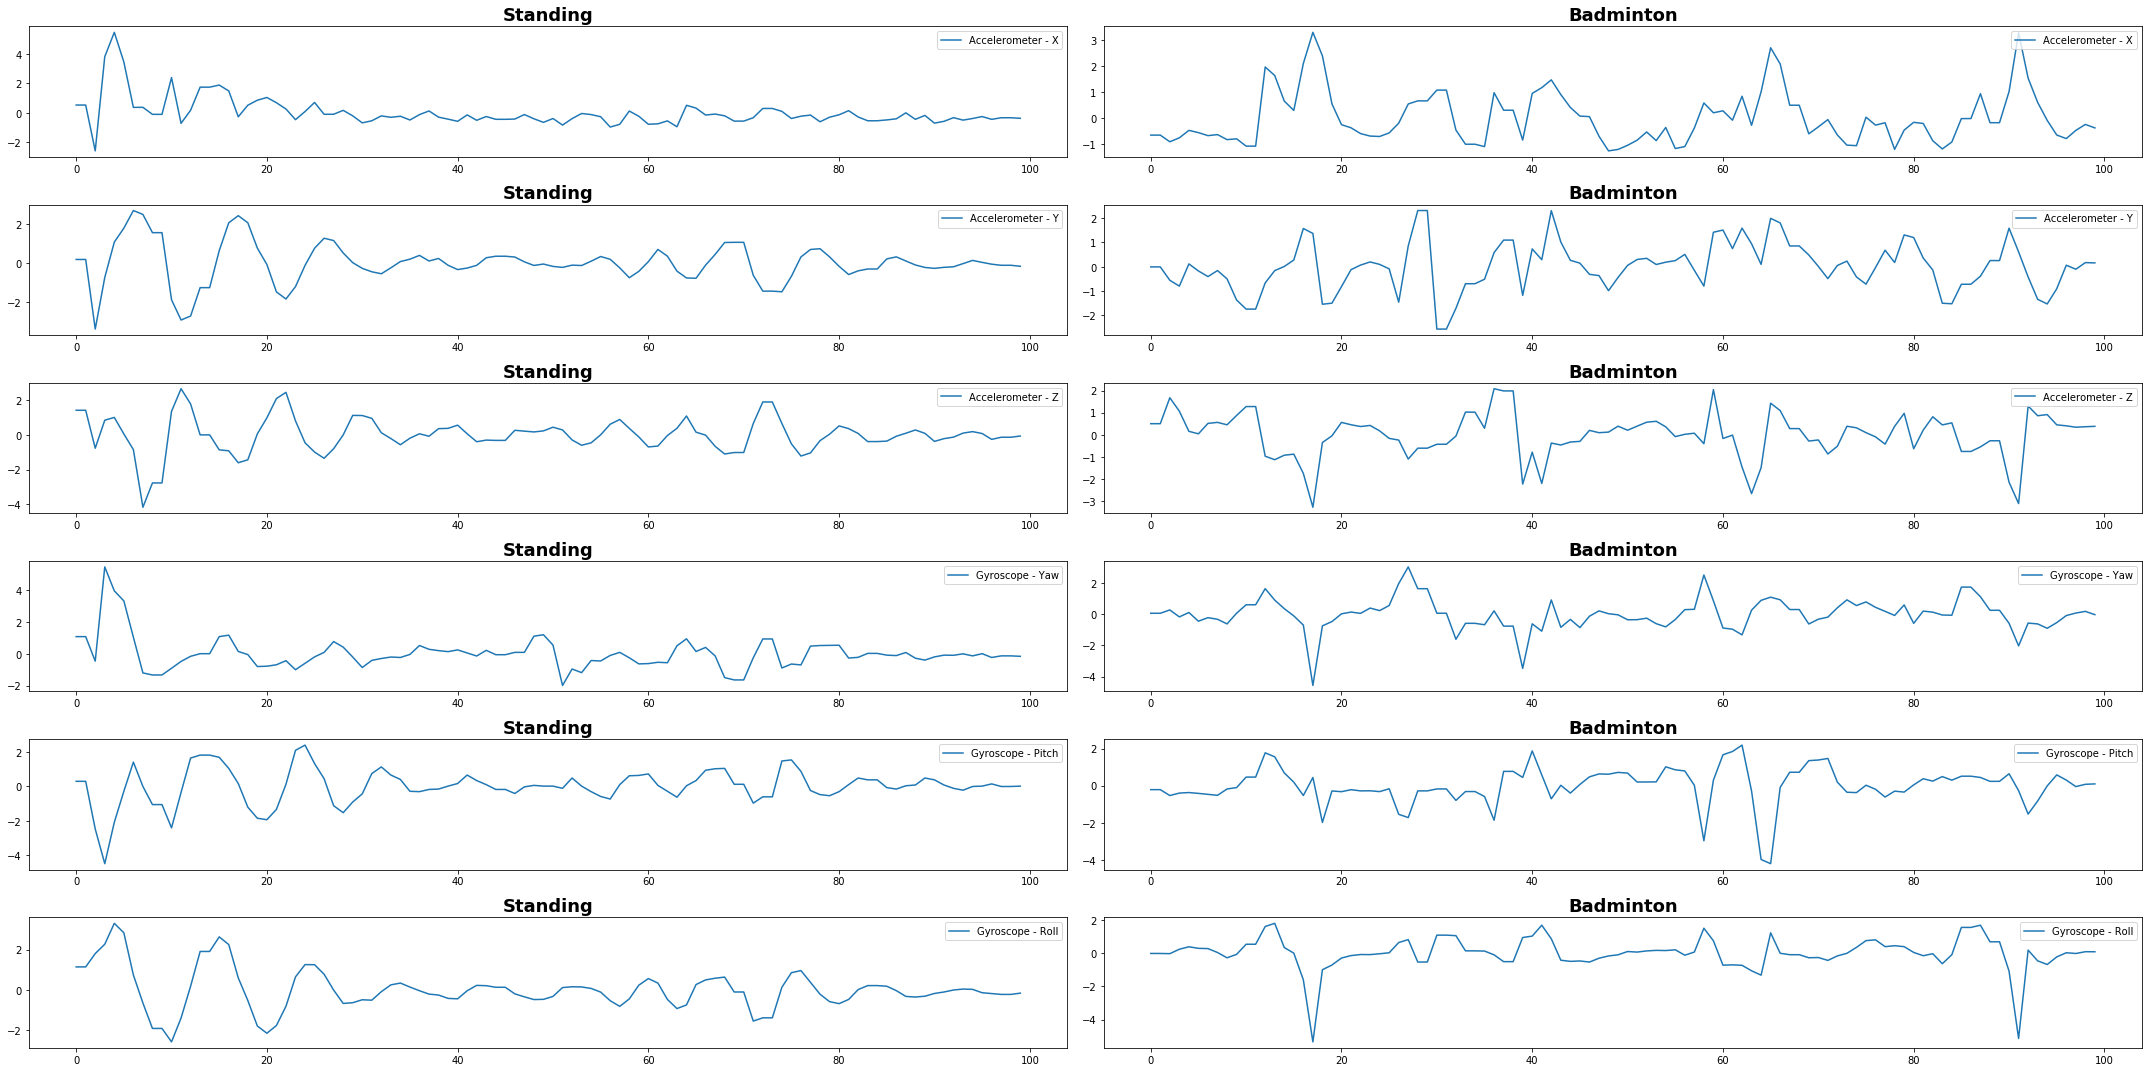

In [15]:
labels = ["Accelerometer - X", "Accelerometer - Y", "Accelerometer - Z", "Gyroscope - Yaw", "Gyroscope - Pitch", "Gyroscope - Roll"]
if True:
    index = 0
    fig = plt.figure(figsize=(30,15))
    axes = []
    for i in range(6):
        axes.append(fig.add_subplot(6,2,2*i+1))
        axes[i].set_title('{}'.format(str(y_train[index])[2:-1]), weight = 'bold', fontsize=18)
        axes[i].plot(X_train[index,i,:], label = labels[i])
        axes[i].legend(loc=1)
    index = -1
    for i in range(6):
        axes.append(fig.add_subplot(6,2,2*(i+1)))
        axes[6+i].set_title('{}'.format(str(y_train[index])[2:-1]), weight = 'bold', fontsize=18)
        axes[6+i].plot(X_train[index,i,:], label = labels[i])
        axes[6+i].legend(loc=1)
plt.tight_layout()

## Causal CNN Encoder - Exploration

This section runs different experiment to investigate the role of the different module of the architecture:

* The global average pooling layer to squeeze the temporal dimension, which is supposed to regularize the model compared to using a fully-connected layer.
* The different hyper-parameters of the model:
        * The depth of the network (i.e the number of causal CNN blocks, e.g 10 by default)
        * The number of channels (e.g 40 by default)


###  Global Average Pooling as a Regularizer

**Model Definition**

In [16]:
in_channels = 6
channels = 40
depth = 4
reduced_size = 160
out_channels = 320
kernel_size = 3
N_sample = 100

# The whole model
causalEncoder = CausalCNNEncoder(in_channels = in_channels, channels = channels, depth = depth,
                                 reduced_size = reduced_size, out_channels = out_channels, kernel_size = kernel_size).double()

# The whole model without the last global average pooling and FC between reduced_size and out_channel
causal_cnn = CausalCNN(in_channels = in_channels, channels = channels, depth = depth, out_channels = out_channels, kernel_size = kernel_size).double()



##### BUILDING EACH BLOCK OF THE MODEL

# Each of the Causal CNN Blocks (of width 4)
ConvBlock_1 = CausalConvolutionBlock(in_channels = in_channels, out_channels = channels, dilation=1, kernel_size=3).double()
ConvBlock_2 = CausalConvolutionBlock(in_channels = channels, out_channels = channels, dilation=2, kernel_size=3).double()
ConvBlock_3 = CausalConvolutionBlock(in_channels = channels, out_channels = channels, dilation=4, kernel_size=3).double()
ConvBlock_4 = CausalConvolutionBlock(in_channels = channels, out_channels = reduced_size , dilation=8, kernel_size=3).double()

# Global average pooling
reduce_size = torch.nn.AdaptiveMaxPool1d(1)

#Squeez the last (third) temporal dimension 
squeeze = SqueezeChannels() 

# last fully connected layer to go from reduced_size to out_channel
linear = torch.nn.Linear(reduced_size, out_channels).double()

**Data shape flow using the global average pooling**

In [17]:
model_from_scratch = [ConvBlock_1, ConvBlock_2, ConvBlock_3, ConvBlock_4, reduce_size, squeeze, linear]
model_name_from_scratch = ['ConvBlock_1', 'ConvBlock_2', 'ConvBlock_3', 'ConvBlock_4', 'Global Average Pooling', 'squeezing', 'final FC']

print('Input Shape:')
print(list(X_train.shape),'\n')
input = X_train
for block_ii in range(len(model_from_scratch)):
    print('{}:'.format(model_name_from_scratch[block_ii]))
    output = model_from_scratch[block_ii](input)
    print(list(output.shape),'\n')
    input = output

Input Shape:
[40, 6, 100] 

ConvBlock_1:
[40, 40, 100] 

ConvBlock_2:
[40, 40, 100] 

ConvBlock_3:
[40, 40, 100] 

ConvBlock_4:
[40, 160, 100] 

Global Average Pooling:
[40, 160, 1] 

squeezing:
[40, 160] 

final FC:
[40, 320] 



**Data shape flow using the a fully-connected layer to squeeze the temporal dimension**

In [19]:
# Instead of the Global Average Pooling
linear_to_squeeze = torch.nn.Linear(N_sample, 1).double()


model_from_scratch_experiment = [ConvBlock_1, ConvBlock_2, ConvBlock_3, ConvBlock_4, linear_to_squeeze, squeeze, linear]
model_name_from_scratch_experiment = ['ConvBlock_1', 'ConvBlock_2', 'ConvBlock_3', 'ConvBlock_4', 'linear_to_squeeze', 'squeezing', 'final FC']

print('Input Shape:')
print(list(X_train.shape),'\n')
input = X_train
for block_ii in range(len(model_from_scratch_experiment)):
    print('{}:'.format(model_name_from_scratch_experiment[block_ii]))
    output = model_from_scratch_experiment[block_ii](input)
    print(list(output.shape),'\n')
    input = output

Input Shape:
[40, 6, 100] 

ConvBlock_1:
[40, 40, 100] 

ConvBlock_2:
[40, 40, 100] 

ConvBlock_3:
[40, 40, 100] 

ConvBlock_4:
[40, 160, 100] 

linear_to_squeeze:
[40, 160, 1] 

squeezing:
[40, 160] 

final FC:
[40, 320] 



**Comparison of the performances**

TODO

### Analysis of the hyperparameters of the model

TODO